In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
date = "28_10_2023"
genotype = "ER4d_sytjGCaMP7f_EPG_jRGECO1a"
fly = "fly1"
session = 'closed_loop-000'
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{genotype}/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{genotype}/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=1)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

In [3]:
f = h5py.File(h5name)
data = f['/data'][:]


In [4]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[1,:,:,:], in_place=False)

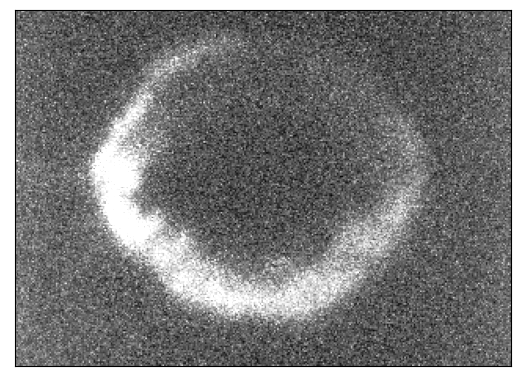

In [5]:
fig, ax = plt.subplots()
# ax.imshow(ref_img[0,:,:,:].max(axis=0), cmap='Greys_r')
im = data_corr[1,:,:,:,:].mean(axis=0).max(axis=0)
ax.imshow(im, cmap='Greys_r', vmax = np.percentile(im,98),vmin=np.percentile(im,0))
ax.set_xticks([])
ax.set_yticks([])
fig.savefig(f'/media/mplitt/SSD_storage/2P_scratch/{genotype}/{date}/{fly}/{session}/ref_img.pdf', format='pdf')

In [6]:
ref_img_file = f'/media/mplitt/SSD_storage/2P_scratch/{genotype}/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, im)


In [7]:
eb_napari = st2p.preprocessing.napari_tools.EB_R4d_Session().new_session(data_corr.mean(axis=1))

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [7]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{genotype}/{date}/{fly}/{session}/napari.pkl'

In [8]:
if True:
    eb_napari = st2p.preprocessing.napari_tools.EB_R4d_Session()
    eb_napari.open_existing_session(napari_outputs_file)

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [9]:
eb_napari.make_phase_masks()


In [9]:
masks_EB = eb_napari.masks_EB
masks_R4d = eb_napari.masks_R4d
bckgnd = eb_napari.background.data

In [10]:
bckgnd.data.shape


(8, 227, 316)

In [11]:
eb_napari.save_layers(napari_outputs_file)

In [12]:
import cloudpickle
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks_EB = np_layers['rois_EB']
masks_R4d = np_layers['rois_R4d']

In [13]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{genotype}/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

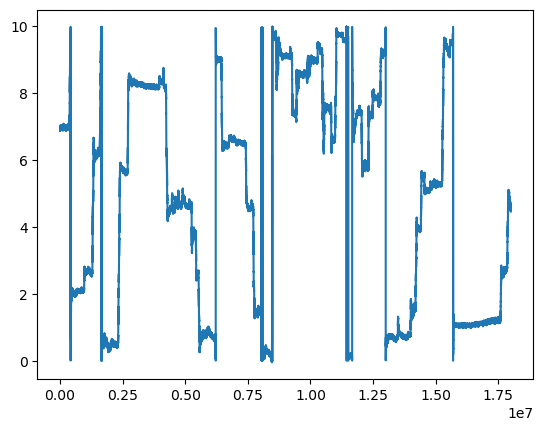

In [14]:
fig,ax = plt.subplots()
ax.plot(np.arange(df.shape[0]),df[' Heading'])

In [15]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [16]:
df_aligned.head()

,Time(ms),Start Trigger,Opto Trigger,FicTrac Cam Exp.,FicTrac Frame Proc.,Heading,Y/Index,Arena DAC1,Arena DAC2,Heading_cartx,Heading_carty,Arena DAC1_cartx,Arena DAC1_carty
0,67.525596,1.0,0.0,1.0,32.0,-1.922070,0.004883,-1.906271,5.070801,-0.344094,-0.938935,-0.329217,-0.944252
1,202.576788,0.0,0.0,0.0,64.0,-1.940003,0.005493,-1.905317,5.074158,-0.360876,-0.932614,-0.328317,-0.944567
2,337.627980,0.0,0.0,0.0,63.0,-1.919357,0.005798,-1.904354,5.082092,-0.341545,-0.939865,-0.327405,-0.944879
3,472.679172,0.0,0.0,0.0,64.0,-1.906810,0.004883,-1.906595,5.070190,-0.329726,-0.944077,-0.329523,-0.944147
4,607.730364,0.0,0.0,0.0,63.0,-1.904331,0.006104,-1.906850,5.066528,-0.327385,-0.944891,-0.329762,-0.944059


In [17]:
df_aligned.columns

Index(['Time(ms)', ' Start Trigger', ' Opto Trigger', ' FicTrac Cam Exp.',
       ' FicTrac Frame Proc.', ' Heading', ' Y/Index', ' Arena DAC1',
       ' Arena DAC2', ' Heading_cartx', ' Heading_carty', ' Arena DAC1_cartx',
       ' Arena DAC1_carty'],
      dtype='object')

In [29]:
F_EB, notF_EB = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks_EB, 16, bckgnd_mask = bckgnd, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [30]:
F_R4d, notF_R4d = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks_R4d, 16, bckgnd_mask = bckgnd, max_proj=False) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [20]:
F_EB.shape

(2, 16, 2666)

In [31]:
import sklearn
from sklearn.linear_model import LinearRegression as LinReg


for ch in range(F_EB.shape[0]):
    lr = LinReg().fit(notF_EB[ch,np.newaxis, :].T, F_EB[ch,:,:].T)
    F_EB[ch,:,:] = F_EB[ch,:,:]-1.*lr.predict(notF_EB[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]




for ch in range(F_R4d.shape[0]):
    lr = LinReg().fit(notF_R4d[ch,np.newaxis, :].T, F_R4d[ch,:,:].T)
    F_R4d[ch,:,:] = F_R4d[ch,:,:]-1.*lr.predict(notF_R4d[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]



# print(lr.coef_)

coef = .7
if True:

    lr = LinReg().fit(F_EB[1,:, :].T, F_EB[0,:,:].T)
    # lr = LinReg().fit(F_EB[1,:,:].mean(axis=0,keepdims=True).T, F_EB[0,:,:].mean(axis=0,keepdims=True).T)
    # F_EB[0,:,:] = np.maximum(F_EB[0,:,:] - coef*lr.coef_*F_EB[1,:,:], 0) + lr.intercept_
    # print(lr.coef_)
    F_EB[0,:,:] = np.maximum(F_EB[0,:,:]-coef*lr.predict(F_EB[1,:,:].T).T,0)  #+ lr.intercept_[:,np.newaxis]

    lr = LinReg().fit(F_R4d[0,:, :].T, F_R4d[1,:,:].T)
    # lr = LinReg().fit(F_R4d[0,:,:].mean(axis=0,keepdims=True).T, F_R4d[1,:,:].mean(axis=0,keepdims=True).T)
    # F_R4d[1,:,:] = np.maximum(F_R4d[1,:,:] - coef*lr.coef_*F_R4d[0,:,:], 0) + lr.intercept_
    # print(lr.coef_)
    F_R4d[1,:,:] = np.maximum(F_R4d[1,:,:]-coef*lr.predict(F_R4d[0,:,:].T).T,0) # + lr.intercept_[:,np.newaxis]
    

notF_EB = sp.ndimage.gaussian_filter1d(notF_EB,3,axis=-1)
F_EB = sp.ndimage.gaussian_filter1d(F_EB,2,axis=-1)
F_EB = sp.ndimage.gaussian_filter1d(F_EB,1.5,axis=1, mode='wrap')



notF_R4d = sp.ndimage.gaussian_filter1d(notF_R4d,3,axis=-1)
F_R4d = sp.ndimage.gaussian_filter1d(F_R4d,2,axis=-1)
F_R4d = sp.ndimage.gaussian_filter1d(F_R4d,1.5,axis=1, mode='wrap')


In [32]:
# F_EB_base = sp.ndimage.minimum_filter1d(sp.ndimage.gaussian_filter1d(F_EB, 50, axis=-1),100, axis=-1)
# F_R4d_base = sp.ndimage.minimum_filter1d(sp.ndimage.gaussian_filter1d(F_R4d, 50, axis=-1), 100, axis=-1)

In [33]:
# dff_EB = sp.stats.zscore(F_EB[0,:,:],axis=-1)
# dff_R4d = sp.stats.zscore(F_R4d[1,:,:],axis=-1)

# dff_EB = sp.stats.zscore((F_EB[0,:,:] - F_EB_base[0,:,:])/F_EB_base[0,:,:],axis=-1)
# dff_R4d = sp.stats.zscore((F_R4d[1,:,:]- F_R4d_base[0,:,:])/F_R4d_base[1,:,:],axis=-1)


# dff_EB = sp.stats.zscore(F_EB[0,:,:]-F_EB[0,:,:].mean(axis=0,keepdims=True),axis=-1)
# dff_R4d = sp.stats.zscore(F_R4d[1,:,:]-F_R4d[1,:,:].mean(axis=0,keepdims=True),axis=-1)

# dff_EB = sp.stats.zscore(F_EB[0,:,:]/F_EB[0,:,:].mean(axis=0,keepdims=True),axis=-1)
# dff_R4d = sp.stats.zscore(F_R4d[1,:,:]/F_R4d[1,:,:].mean(axis=0,keepdims=True),axis=-1)

dff_R4d = sp.stats.zscore(F_R4d[1,:,:]/np.linalg.norm(F_R4d[1,:,:], axis=0, keepdims=True), axis=-1)
dff_EB = sp.stats.zscore(F_EB[0,:,:]/np.linalg.norm(F_EB[0,:,:], axis=0, keepdims=True), axis=-1)



In [34]:

x_f,y_f = st2p.utilities.pol2cart(dff_R4d,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
x_f_r,y_f_r = st2p.utilities.pol2cart(dff_EB,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])


_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))


rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

rho_r,phi_r = st2p.utilities.cart2pol(x_f_r.mean(axis=0), y_f_r.mean(axis=0))
_,offset_r = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi_r-heading))


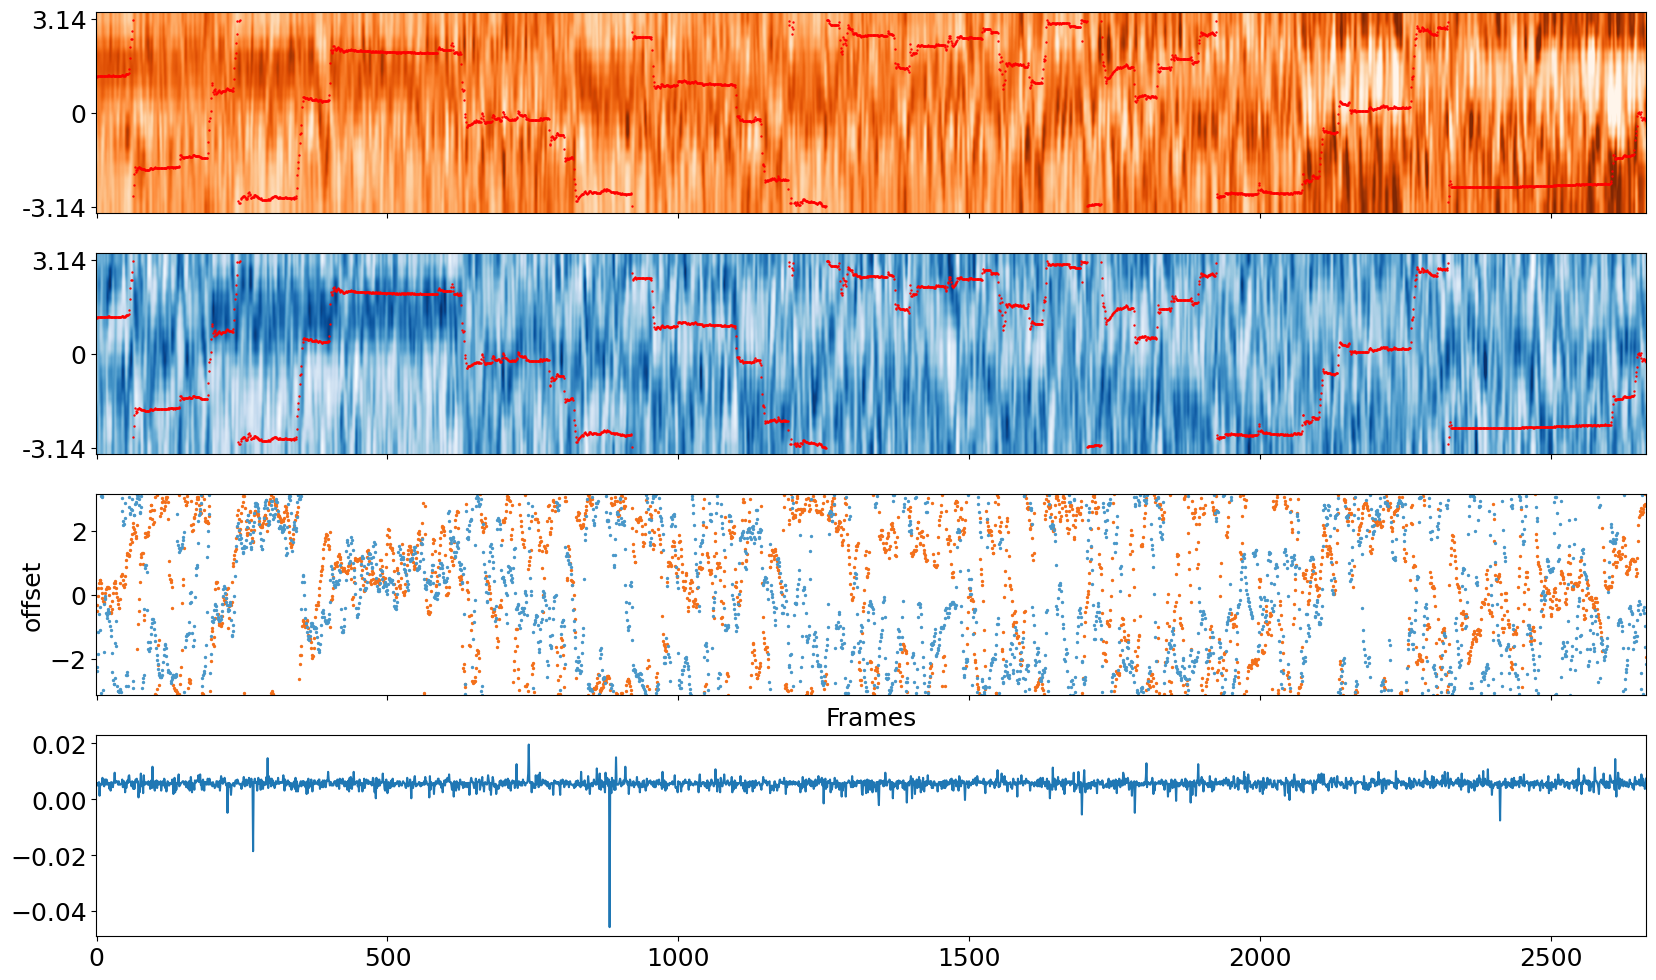

In [35]:
win_size = 6000
plt.rcParams.update({'font.size':18})

for num_fig, start_i in enumerate(range(0,dff_EB.shape[-1]-3,win_size)):
    stop_i = min(start_i+win_size, dff_EB.shape[-1]-1)
    window = slice(start_i, stop_i)
    x = np.arange(stop_i-start_i)
    
    fig, ax = plt.subplots(4,1,figsize=[20,12], sharex=True)
    dff_window = dff_R4d[:,window]
    ax[0].imshow(dff_window,aspect='auto',cmap='Oranges',vmin=-3,vmax=3)
    # ax[0].set_xticks(frame_times)
    ax[0].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
    # ax[0].set_ylabel(r"ASAP $ - \Delta F/F$")
    # # ax[0].set_xticklabels([-3.14, 0, 3.14])

    ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
    # ax[0].scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='black', s=2)

    dff_r_window = dff_EB[:,window]
    ax[1].imshow(dff_r_window,aspect='auto',cmap='Blues',vmin=-3,vmax=3)
    ax[1].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)
    ax[1].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
    # ax[1].set_ylabel(r"jRGECO $\Delta F/F$")
    # ax[1].scatter(x,15*(phi_r[window]+np.pi)/2/np.pi,color='black', s=2)



    ax[2].scatter(x,offset[window],s=2, color=plt.cm.Oranges(.6))
    ax[2].scatter(x,offset_r[window],s=2, color=plt.cm.Blues(.6))
    ax[2].set_ylim([-3.14,3.14])
    # # ax[1].plot(x,0*offset[window], marker='_')


    ax[2].set_ylabel('offset')
    ax[2].set_xlabel('Frames')
    
    ax[3].plot(x,df_aligned[' Y/Index'].iloc[window])


    # ax[2].set_xticks(x[0::500], labels=[str(int((frame_times[i]-frame_times[0])/1000)) for i in range(0,x[-1]+1,500)])
    

Text(0.5, 0, 'offset')

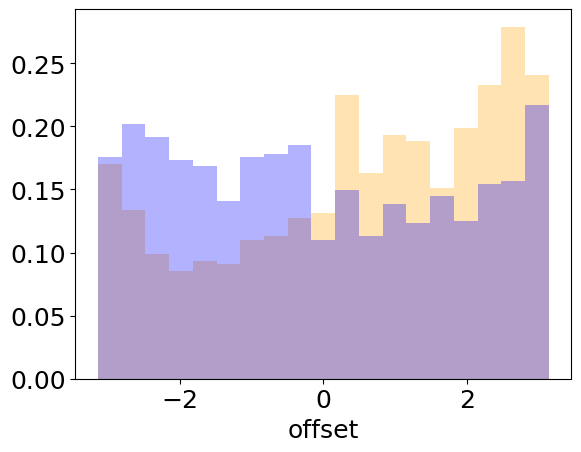

In [36]:
h_x, h_y = st2p.utilities.pol2cart(np.ones(heading.shape), np.diff(heading,prepend=0))
_, dh = st2p.utilities.cart2pol(h_x, h_y)

fig,ax = plt.subplots()
bin_edges=np.linspace(-np.pi,np.pi,num=20)

mask = np.ones(offset.shape)>0
# mask[:] = False
# mask[:200]=False
# mask=np.abs(dh)>.1
ax.hist(offset[mask],bins = bin_edges, alpha=.3, color='orange',density=True)
ax.hist(offset_r[mask],bins = bin_edges, alpha=.3, color='blue',density=True)
ax.set_xlabel('offset')
# fig.savefig(os.path.join(fig_folder,'offset_hist.jpg'))

In [37]:

max_inds = (15*(heading+np.pi)/2/np.pi).astype(int)
dff_EB_maxal = 0*dff_EB
dff_R4d_maxal = 0*dff_EB
for t in range(dff_EB.shape[1]):
    dff_EB_maxal[:,t] = np.roll(dff_EB[:,t], -max_inds[t]-8)
    dff_R4d_maxal[:,t] = np.roll(dff_R4d[:,t], -max_inds[t]-8)

# dff_EB_maxal = dff_EB_maxal/np.linalg.norm(dff_EB_maxal, axis=0, keepdims=True)
# dff_R4d_maxal = dff_R4d_maxal/np.linalg.norm(dff_R4d_maxal, axis=0, keepdims=True)

Text(0, 0.5, 'Normalized activity')

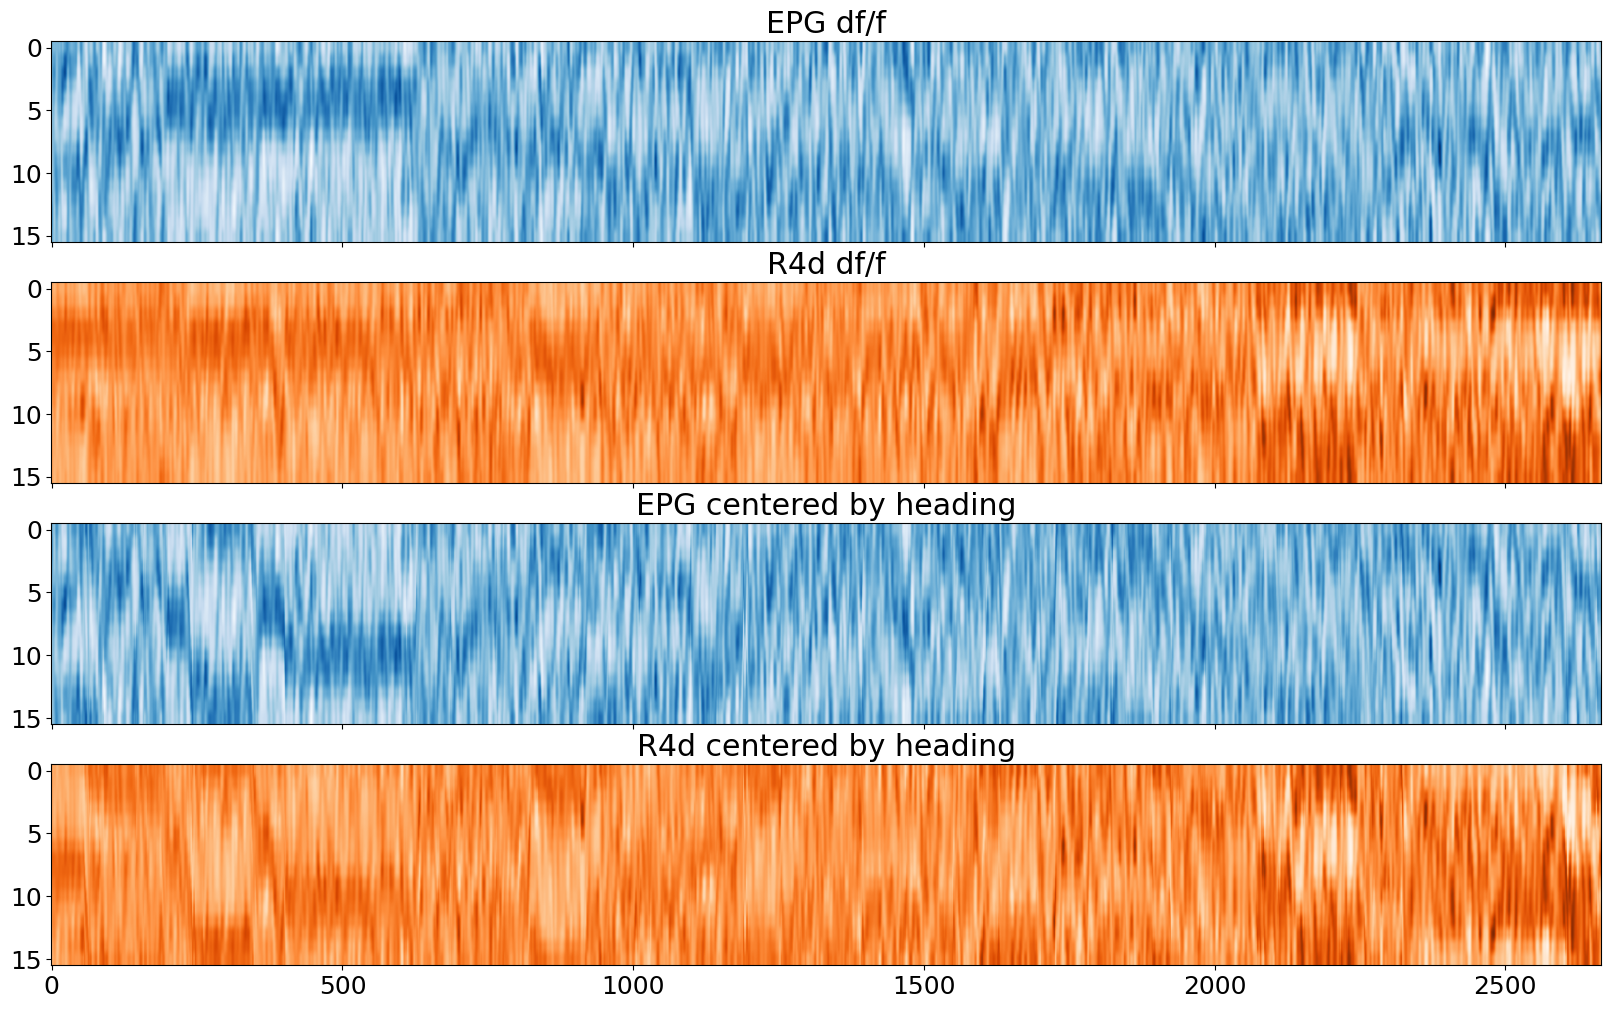

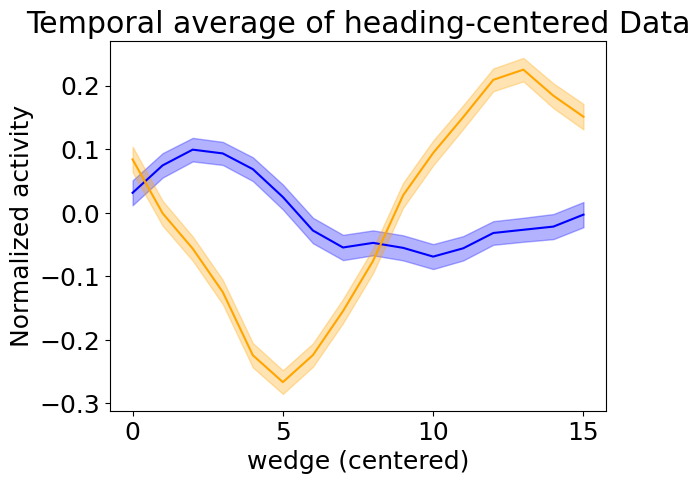

In [38]:
start, end = 0, dff_EB.shape[1]

fig, ax = plt.subplots(4,1, figsize=[20,12], sharex=True)
ax[0].imshow(dff_EB[:,start:end],aspect='auto',cmap='Blues', interpolation=None)
ax[0].set_title('EPG df/f')
ax[1].imshow(dff_R4d[:,start:end],aspect='auto',cmap='Oranges',interpolation=None)
ax[1].set_title('R4d df/f')
ax[2].imshow(dff_EB_maxal[:,start:end],aspect='auto',cmap='Blues', interpolation=None) #,vmin=-3,vmax=3)
ax[2].set_title('EPG centered by heading')
ax[3].imshow(dff_R4d_maxal[:,start:end],aspect='auto',cmap='Oranges', interpolation=None) #,vmin=-3,vmax=3)
ax[3].set_title('R4d centered by heading')


fig, ax = plt.subplots()
mu, sem = dff_EB_maxal[:,start:end].mean(axis=-1), sp.stats.sem(dff_EB_maxal[:, start:end], axis=-1)

ax.plot(mu, color='blue')
ax.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='blue')
# ax2 = ax.twinx()
mu, sem = dff_R4d_maxal[:,start:end].mean(axis=-1), sp.stats.sem(dff_R4d_maxal[:, start:end], axis=-1)

# ax2.plot(mu, color='orange')
# ax2.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='orange')
ax.plot(mu, color='orange')
ax.fill_between(np.arange(16), mu-sem, mu+sem, alpha=.3, color='orange')
ax.set_title('Temporal average of heading-centered Data')
ax.set_xlabel('wedge (centered)')
ax.set_ylabel('Normalized activity')